In [1]:
import sys
sys.path.insert(0, '../../')
%load_ext autoreload
%autoreload 2
from TPHATE.tphate import tphate

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scprep


In [2]:
# Generate random autocorrelative data
def f(x, a, sigma):
    noisy = a*x + np.random.normal(0.0, sigma, size=x.shape)
    return noisy

features, samples=100,80
X = np.ones((features, samples))*np.arange(samples)
Ys = np.array([f(x, 2, 10) for x in X]).T # want samples x features input (timepoints by voxels)
Ys.shape

(80, 100)

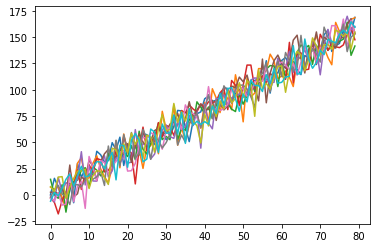

In [3]:
# plot data
_=plt.plot(Ys[:,::10])

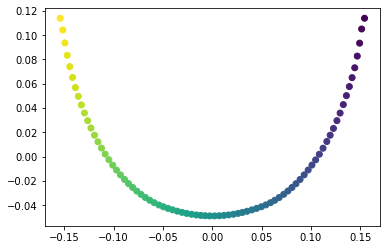

In [4]:
# Embed with tphate
tphate_op = tphate.TPHATE(n_jobs=-1, verbose=0, t=5, 
                          mds='metric', mds_solver='sgd', smooth_window=4)
embedding = tphate_op.fit_transform(Ys)
plt.scatter(embedding[:,0], embedding[:,1], c=np.arange(80))

In [5]:
tphate_op.dropoff

30

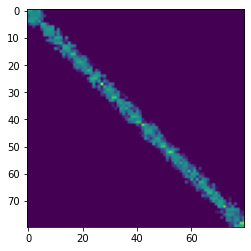

In [6]:
# Plot the PHATE diffusion operator
plt.imshow(tphate_op.phate_diffop)

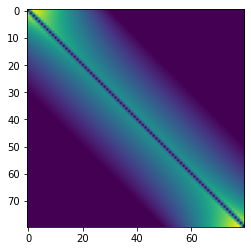

In [7]:
# plot the autocorrelation kernel
plt.imshow(tphate_op.autocorr_op)

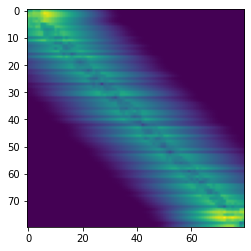

In [8]:
# Plot the combined TPHATE diffusion op
plt.imshow(tphate_op.diff_op)

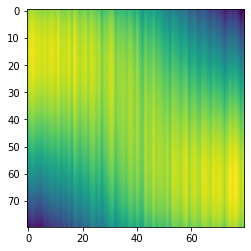

In [9]:
plt.imshow(tphate_op._diff_potential)

In [10]:
ds = np.load('../src_data/sub-04_aud_early_sherlock_movie.npy')

In [11]:
tphate_op = tphate.TPHATE(n_jobs=-1, t=5, mds='metric', mds_solver='sgd',smooth_window=1)
embedding = tphate_op.fit_transform(ds)

Calculating TPHATE...
  Running TPHATE on 1976 observations and 1018 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.09 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.22 seconds.
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 28
  Combining PHATE operator and autocorr operator
  Calculating diffusion potential...
  Calculated diffusion potential in 0.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.30 seconds.
Calculated TPHATE in 9.41 seconds.


<AxesSubplot:>

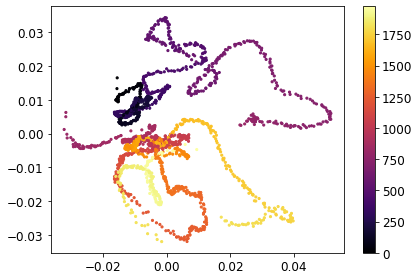

In [12]:
scprep.plot.scatter2d(embedding, c=np.arange(len(embedding)))

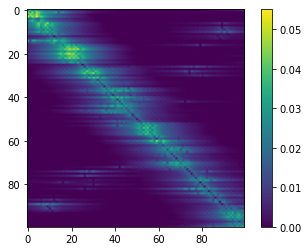

In [13]:
plt.imshow(tphate_op.diff_op[:100,:100])
plt.colorbar()

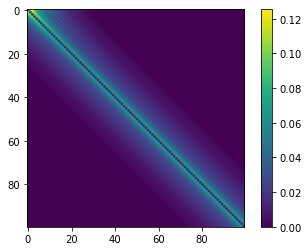

In [14]:
plt.imshow(tphate_op.autocorr_op[:100,:100])
plt.colorbar()

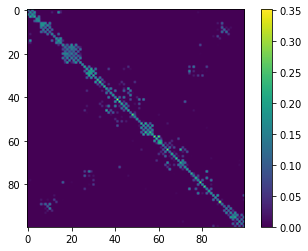

In [15]:
plt.imshow(tphate_op.phate_diffop[:100,:100])
plt.colorbar()

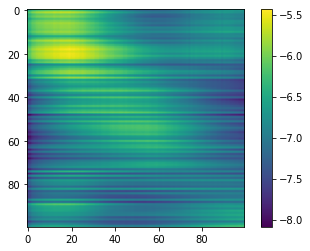

In [16]:
plt.imshow(tphate_op.diff_potential[:100,:100])
plt.colorbar()

In [17]:
tphate_op.dropoff

28